<a href="https://colab.research.google.com/github/sidharth178/The-Battle-of-Neighborhoods-Capstone-Project/blob/master/The_Battle_Of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

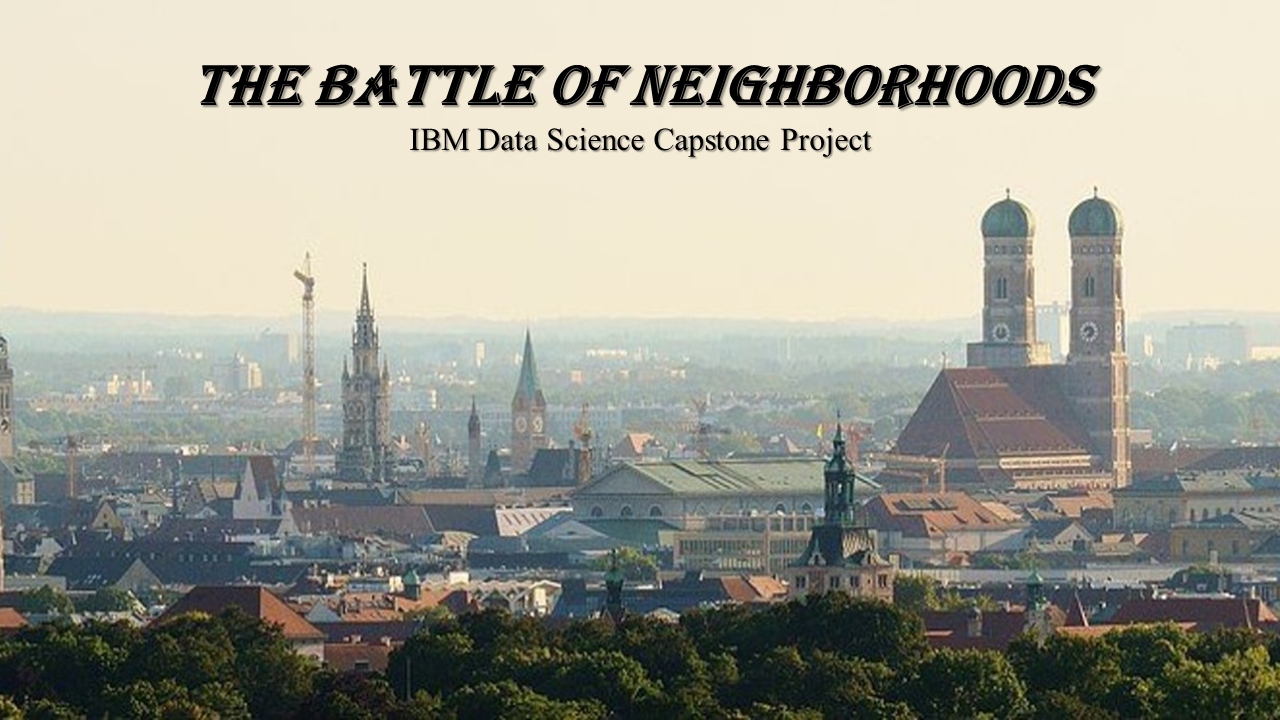

# **1. Introduction**

### **Objective**
The objective of this project is to find the best neighbourhood in Toronto to open a Italian restaurant using Foursquare location data. In this project we’ll go through the solution for this problem for avoiding or considering low risk criteria and high success rate.
### **Target Audiance**
* Business personnel who wants to invest or open a restaurant.
* The freelancer who loves to have their own restaurant as a side business.
* Torrists who wants to eat italian food.

### **Data Description**
For this project we need these following data:
1. ***Toronto City data that contains Borough, Neighborhoods along with there latitudes and longitudes***
* **Data Source:** https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
* **Description:** This Wikipedia page contain all the information we need to explore and cluster the neighborhoods in Toronto. We will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the Toronto dataset.
2. ***Geographical Location data using Geocoder Package***
* **Data Source:** https://cocl.us/Geospatial_data
* **Description:** The second source of data provided us with the Geographical coordinates of the neighbourhoods with the respective Postal Codes.
3. ***Venue Data using Foursquare API***
* **Data Source:** https://foursquare.com/developers/apps
* **Description:** From Foursquare API we can get the name,category,latitude,longitude for each venue.

In this capstone project we are going to answer of these following major steps:

* **Assignment-1:** Scrape the data from the wikipedia page of Toronto.

* **Assignment-2:**  Get the geographical coordinates of the neighborhoods using the Geocoder package.

* **Assignment-3:** Explore and cluster the neighborhoods in Toronto.

### **Blog Post(Medium)**
 Check [here](https://sidharth178.medium.com/the-battle-of-neighborhoods-f3f8bff9abf3)

# **2. Import Libraries**

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# **3. Scrape Neighborhoods Data**

In [2]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [3]:
# loop through table, grab each of the 3 columns shown
# Scrape the neighborhood data from the table in the wikipedia page of Toronto
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        # here we replace some symbols like "(" , ")" , "/" from the neighborhood name(Ex: (Parkview Hill / Woodbine Gardens))
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [4]:
# save this dataframe in a CSV file
df.to_csv('Neighborhood Data.csv')

# **4. Data Pre-processing**
In this step we'll do thses following steps
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11  in the above table.
- If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.




In [5]:
# drop rows having null value and value assigned as "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [6]:
# check for missing value
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [7]:
# Check if we still have any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [8]:
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [9]:
# shape of dataframe
df.shape

(103, 3)

Now  data is cleaned and all the requirements are met. So we just have to add the Latitude and Longitudes of each location.


Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. Now we are going to create a new table with the Latitudes and Longitudes corresponding to the different PostalCodes

In [10]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Now we'll merge the **geographical dataframe** with **neighborhood dataframe** according to the **Postal Code**

In [11]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [12]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

### 4.1. Now we will find all neighborhoods that have the _Toronto_ in it

In [13]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [14]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [15]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.39715291165048


In [16]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [17]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

### 4.2. Next we will define foursquare Credentials

In [18]:

CLIENT_ID = 'CURLH5YYCXMLJUABNE5Y22LK1JNKWHZLO5MCW2OD4PRRRDK1' # your Foursquare ID
CLIENT_SECRET = 'O5PCL405KIK4MGGBIMJD2EIAYSEIQK03W4QMEG4L4ZYOEMMF' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')

Credentials Stored


### 4.3. Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.

First, let's create the GET request URL

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [21]:
toronto_venues.tail()

Neighborhood  \
1969  Mimico NW, The Queensway West, South of Bloor,...   
1970  Mimico NW, The Queensway West, South of Bloor,...   
1971  Mimico NW, The Queensway West, South of Bloor,...   
1972  Mimico NW, The Queensway West, South of Bloor,...   
1973  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
1969              43.628841              -79.520999   
1970              43.628841              -79.520999   
1971              43.628841              -79.520999   
1972              43.628841              -79.520999   
1973              43.628841              -79.520999   

                                      Venue  Venue Latitude  Venue Longitude  \
1969                Jim & Maria's No Frills       43.631152       -79.518617   
1970  Koala Tan Tanning Salon & Sunless Spa       43.631370       -79.519006   
1971                      Once Upon A Child       43.631075       -79.518290   
1972                   Kingsway Boxing Club       43.627254       -79.526684   
1973                           Burrito Boyz       43.626657       -79.526349   

     Venue Category  
1969  Grocery Store  
1970  Tanning Salon  
1971     Kids Store  
1972            Gym  
1973  Burrito Place

Lets check how many venues are there per neighborhood

In [22]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  6   
Bathurst Manor, Wilson Heights, Downsview North                        18   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      24   
Berczy Park                                                            47   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           24   
CN Tower, King and Spadina, Railway Lands, Harb...                     14   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               7   
Central Bay Street                                                     63   
Christie                                                               14   
Church and Wellesley                                                   68   
Clairville, Humberwood, Woodbine Downs, West Hu...                      3   
Clarks Corners, Tam O'Shanter, Sullivan                                10   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             26   
Davisville North                                                        8   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         6   
Don Mills South                                                        15   
Dorset Park, Wexford Heights, Scarborough Town ...                      6   
Downsview Central                                                       3   
Downsview East                                                          3   
Downsview Northwest                                                     5   
Downsview West                                                          4   
Dufferin, Dovercourt Village                                           14   
Enclave of L4W                                                         14   
Enclave of M4L                                                         16   
Enclave of M5E                                                         85   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                     10   
Fairview, Henry Farm, Oriole                                           61   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                         9   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          17   
Hillcrest Village                                                       5   
Humber Summit                                                           1   
Humberlea, Emery                                                        2   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         17   
Islington Avenue                                                        1   
Kennedy Park, Ionview, East Birchmount Park                             3   
Kensington Market, Chinatown, Grange Park                              57   
Kingsview Village, St. Phillips, Martin Grove G.

### 4.4. How many unique venues are there?

In [23]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 257 uniques vanue categories.


In [24]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Fast Food Restaurant' 'Park' 'Food & Drink Shop' 'Hockey Arena'
 'Portuguese Restaurant' 'Coffee Shop' 'Pizza Place' 'Bakery'
 'Distribution Center' 'Spa' 'Restaurant' 'Historic Site' 'Farmers Market'
 'Chocolate Shop' 'Performing Arts Venue' 'Greek Restaurant' 'Pub'
 'Breakfast Spot' 'Dessert Shop' 'Event Space' 'Bank' 'Café'
 'Sandwich Place' 'Theater' 'French Restaurant' 'Art Gallery' 'Beer Store'
 'Mexican Restaurant' 'Asian Restaurant' 'Electronics Store'
 'Discount Store' 'Hotel' 'Wine Shop' 'Sushi Restaurant' 'Antique Shop'
 'Boutique' 'Vietnamese Restaurant' 'Clothing Store' 'Miscellaneous Shop'
 'Gift Shop' 'Furniture / Home Store' 'Yoga Studio' 'Burger Joint'
 'Persian Restaurant' 'Diner' 'Japanese Restaurant' 'Burrito Place' 'Bar'
 'Gym' 'College Auditorium' 'College Cafeteria' 'Caribbean Restaurant'
 'Athletics & Sports' 'Construction & Landscaping' 'Gastropub'
 'Gym / Fitness Center' 'Pharmacy' 'Pet Store' 'Intersection'
 'Flea Market' 'Comic Sho

## 4.5. Are there any Italian Restaurants in the venues?

In [52]:
"Italian Restaurant" in toronto_venues['Venue Category'].unique()

True

# **5. Data Analysis**

### 5.1. Now we will analyze each neighborhood

In [26]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1974, 258)


Neighborhoods  Adult Boutique  Afghan Restaurant  Airport  \
0         Parkwoods               0                  0        0   
1         Parkwoods               0                  0        0   
2         Parkwoods               0                  0        0   
3  Victoria Village               0                  0        0   
4  Victoria Village               0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                    0                 0                   0              0   
1                    0                 0                   0              0   
2                    0                 0                   0              0   
3                    0                 0                   0              0   
4                    0                 0                   0              0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0                 0                 0                   0      0   
1                 0                 0                   0      0   
2                 0                 0                   0      0   
3                 0                 0                   0      0   
4                 0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0                0         0           0                   0       0   
1                0         0           0                   0       0   
2                0         0           0                   0       0   
3                0         0           0                   0       0   
4                0         0           0                   0       0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0           0              0          0         0                     0   
1           0              0          0         0                     0   
2           0              0          0         0                     0   
3           0              0          0         0                     0   
4           0              0          0         0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Burger Joint  \
0               0        0            0                0             0   
1               0        0            0                0             0   
2               0        0            0                0             0   
3               0        0            0                0             0   
4               0        0            0                0             0   

   Burrito Place  B

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [27]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(101, 258)


Neighborhoods  Adult Boutique  \
0                                        Agincourt             0.0   
1                           Alderwood, Long Branch             0.0   
2  Bathurst Manor, Wilson Heights, Downsview North             0.0   
3                                  Bayview Village             0.0   
4                Bedford Park, Lawrence Manor East             0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.041667   

   Antique Shop  Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0           0.0       0.0          0.0                  0.0               0.0   
1           0.0       0.0          0.0                  0.0               0.0   
2           0.0       0.0          0.0                  0.0               0.0   
3           0.0       0.0          0.0                  0.0               0.0   
4           0.0       0.0          0.0                  0.0               0.0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  \
0                 0.0            0.0        0.0         0.0         0.0   
1                 0.0            0.0        0.0         0.0         0.0   
2                 0.0            0.0        0.0         0.0         0.0   
3                 0.0            0.0        0.0         0.0         0.0   
4                 0.0            0.0        0.0         0.0         0.0   

   Bakery      Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0.0  0.000000  0.0             0.0               0.0               0.0   
1     0.0  0.000000  0.0             0.0               0.0               0.0   
2     0.0  0.111111  0.0             0.0               0.0               0.0   
3     0.0  0.250000  0.0             0.0               0.0               0.0   
4     0.0  0.000000  0.0             0.0               0.0               0.0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  \
0                 0.0    0.0              0.0       0.0         0.0   
1                 0.0    0.0              0.0       0.0         0.0   
2                 0.0    0.0              0.0       0.0         0.0   
3                 0.0    0.0              0.0       0.0         0.0   
4                 0.0    0.0              0.0       0.0         0.0   

   Belgian Restaurant  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0                 0.0     0.0         0.0            0.0        0.0       0.0   
1                 0.0     0.0         0.0            0.0        0.0       0.0   
2                 0.0     0.0         0.0            0.0        0.0       0.0   
3                 0.0     0.0         0.0            0.0        0.0       0.0   
4                 0.0     0.0         0.0            0.0        0.0       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0            0.25      0.0     0.000000   
1                   0.0            0.00      0.0     0.000000   
2                   0.0            0.00      0.0     0.055556   
3                   0.0            0.00      0.0     0.000000   
4                   0.0            0.00      0.0     0.000000   

   Bubble Tea Shop  Burger

Here we only require the "Neighborhoods" and "Italian Restaurant" columns for the clustering. So we'll group these two columns.

In [28]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head()

Neighborhoods  Italian Restaurant
0                                        Agincourt            0.000000
1                           Alderwood, Long Branch            0.000000
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000
3                                  Bayview Village            0.000000
4                Bedford Park, Lawrence Manor East            0.041667

In [29]:
# rename column "Neighborhoods" to "Neighborhood"
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})


# **6. Clustering**
We will use k-means clustering. But first we will find the best _K_ value using the **Elbow Point** method.

### 6.1. Elbow Method

In [30]:
# drop "Neighborhood" column from the dataframe
X = ita.drop(['Neighborhood'], axis=1)

C:\Users\krojas\localapps\miniconda3\envs\capstone\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\krojas\localapps\miniconda3\envs\capstone\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


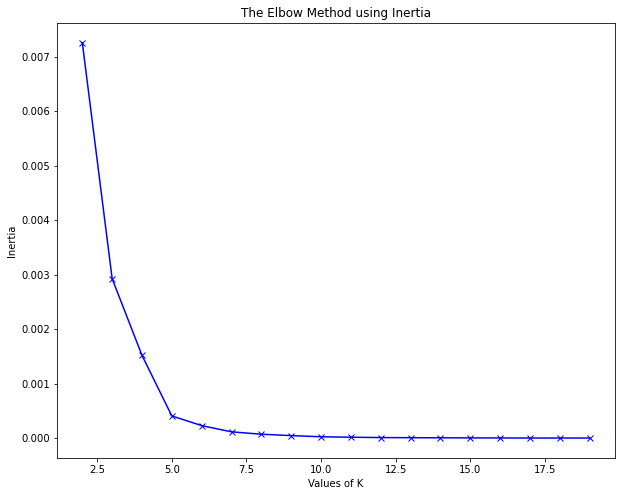

In [31]:
# find 'k' value by Elbow Method
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Here,We saw that the optimum K value is 4 so we will have a resulting of 4 clusters.

In [32]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 2, 0, 2, 0, 0])

In [33]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

In [34]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [35]:
to_merged.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.041667   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [36]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1974, 9)


Neighborhood  Italian Restaurant  Cluster Labels  \
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                     El Pulgarcito       43.792648       -79.259208   
0                          Twilight       43.791999       -79.258584   
0                   Commander Arena       43.794867       -79.267989   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0  Latin American Restaurant  
0                     Lounge  
0               Skating Rink  
1                Pizza Place

In [37]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(1974, 9)


Neighborhood  Italian Restaurant  \
15  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
15  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
15  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
15  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
15  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
15               3              43.781638              -79.304302   
15               3              43.781638              -79.304302   
15               3              43.781638              -79.304302   
15               3              43.781638              -79.304302   
15               3              43.781638              -79.304302   

                                 Venue  Venue Latitude  Venue Longitude  \
15                                 KFC       43.780400       -79.300700   
15                            Kub Khao       43.780438       -79.299837   
15  The Royal Chinese Restaurant 避風塘小炒       43.780505       -79.298844   
15                     TD Canada Trust       43.779169       -79.303617   
15                        Petro-Canada       43.779337       -79.307682   

          Venue Category  
15  Fast Food Restaurant  
15       Thai Restaurant  
15    Chinese Restaurant  
15                  Bank  
15           Gas Station

Lets check how many Italian Restaurant are there

In [38]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']

37

We see that there are a total of **45** locations with Italian Restaurants in Toronto  
We will create a new dataframe with the Neighborhood and Italian Restaurants

In [39]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

## 6.2. How many Neighborhoods per Cluster?


In [40]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.041667   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

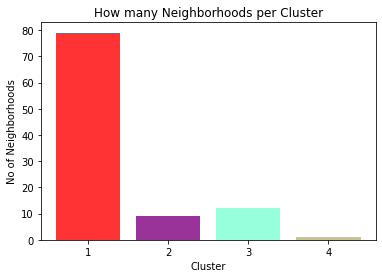

In [41]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [42]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    79
2    12
1     9
3     1
Name: Cluster Labels, dtype: int64

## 6.3. Analysis of each Cluster

### Cluster 1

In [43]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [44]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough      Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York         Parkwoods                 0.0               0   
1  North York         Parkwoods                 0.0               0   
2  North York         Parkwoods                 0.0               0   
3  North York  Victoria Village                 0.0               0   
4  North York  Victoria Village                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude                   Venue  \
0              43.753259              -79.329656           Variety Store   
1              43.753259              -79.329656         Brookbanks Park   
2              43.753259              -79.329656                     KFC   
3              43.725882              -79.315572  Victoria Village Arena   
4              43.725882              -79.315572              Pizza Nova   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.751974       -79.333114     Food & Drink Shop  
1       43.751976       -79.332140                  Park  
2       43.754387       -79.333021  Fast Food Restaurant  
3       43.723481       -79.315635          Hockey Arena  
4       43.725824       -79.312860           Pizza Place

### Cluster 2

In [45]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough     Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York  Don Mills South            0.066667               1   
1  North York  Don Mills South            0.066667               1   
2  North York  Don Mills South            0.066667               1   
3  North York  Don Mills South            0.066667               1   
4  North York  Don Mills South            0.066667               1   

   Neighborhood Latitude  Neighborhood Longitude  \
0                43.7259              -79.340923   
1                43.7259              -79.340923   
2                43.7259              -79.340923   
3                43.7259              -79.340923   
4                43.7259              -79.340923   

                               Venue  Venue Latitude  Venue Longitude  \
0                        Pho 88 發發餐廳       43.726642       -79.342345   
1           Real Canadian Superstore       43.722704       -79.337508   
2  Japanese Canadian Cultural Centre       43.726429       -79.334971   
3                           Harvey's       43.726603       -79.341035   
4                       Asian Legend       43.726591       -79.342188   

       Venue Category  
0    Asian Restaurant  
1         Supermarket  
2         Art Gallery  
3          Restaurant  
4  Dim Sum Restaurant

### Cluster 3

In [46]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough              Neighborhood  Italian Restaurant  \
0  Downtown Toronto  Garden District, Ryerson                0.02   
1  Downtown Toronto  Garden District, Ryerson                0.02   
2  Downtown Toronto  Garden District, Ryerson                0.02   
3  Downtown Toronto  Garden District, Ryerson                0.02   
4  Downtown Toronto  Garden District, Ryerson                0.02   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               2              43.657162              -79.378937   
1               2              43.657162              -79.378937   
2               2              43.657162              -79.378937   
3               2              43.657162              -79.378937   
4               2              43.657162              -79.378937   

                             Venue  Venue Latitude  Venue Longitude  \
0                      Tim Hortons       43.653625       -79.377732   
1  Hokkaido Ramen Santouka らーめん山頭火       43.656435       -79.377586   
2             Donatello Restaurant       43.657489       -79.383605   
3                  Fine Asian Bowl       43.655387       -79.380326   
4                  Balzac's Coffee       43.657854       -79.379200   

          Venue Category  
0            Coffee Shop  
1       Ramen Restaurant  
2     Italian Restaurant  
3  Vietnamese Restaurant  
4            Coffee Shop

### Cluster 4

In [47]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough                             Neighborhood  Italian Restaurant  \
0  Scarborough  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
1  Scarborough  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
2  Scarborough  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
3  Scarborough  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   
4  Scarborough  Clarks Corners, Tam O'Shanter, Sullivan                 0.1   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               3              43.781638              -79.304302   
1               3              43.781638              -79.304302   
2               3              43.781638              -79.304302   
3               3              43.781638              -79.304302   
4               3              43.781638              -79.304302   

                    Venue  Venue Latitude  Venue Longitude  \
0  Remezzo Italian Bistro       43.778649       -79.308264   
1             Gusto Pizza       43.783607       -79.298983   
2    Little Caesars Pizza       43.780563       -79.298624   
3              A&W Canada       43.780327       -79.299060   
4             Tim Hortons       43.781539       -79.298907   

         Venue Category  
0    Italian Restaurant  
1           Pizza Place  
2           Pizza Place  
3  Fast Food Restaurant  
4           Coffee Shop

## 6.4. Number of neighborhoods per cluster *vs* Average number of Italian Restaurants in each Cluster

Text(0.5, 1.0, 'Average number of Italian Restaurants per Cluster')

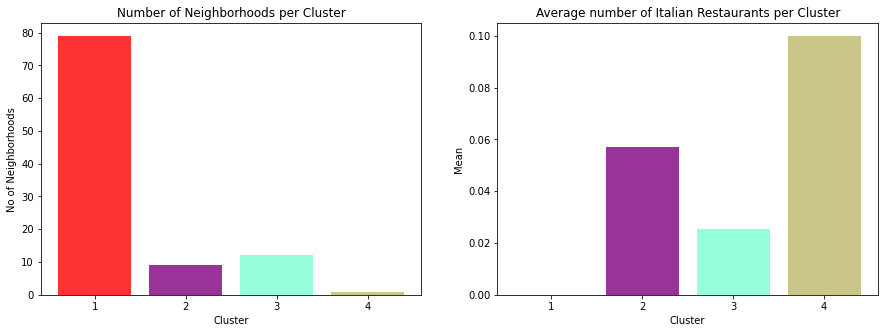

In [48]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                df_cluster4['Italian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')


# **7. Conclusion**

The Neighborhoods located in the East Toronto area(cluster-3) have the highest average of Italian Restaurants which is represented by aquamarine colour. North York has second heighest number of Italian restaurants present. Looking at the nearby venues, the optimum place to put a new Italian Restaurant is in Victoria village,North York(cluster-1) as their are many Neighborhoods in that area but a little number of Italian Restaurants therefore, eliminating any competition.The second best Neighborhoods that have a great oppurtunity would be in areas such as Queen's Park which is in Cluster 4.Having 70 neighborhoods in the area with no Italian Restaurants gives a good oppurtunity for opening up a new restaurant. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Italian restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere.
  

# **8. Future Work**

* Apply different types of clustering algorithms to cluster the 
neighborhoods.
* Consider other food vanues,market area etc. as features for clustering.
* Consider more then 100 vanues in a neighborhood for analysis using Foursquare api.
